# Spherical Harmonic analysis, DETOX models

This notebook can be used to reproduce Fig. G1 and G2 of Hosseini et al. (2020):

```
Kasra Hosseini, Karin Sigloch, Maria Tsekhmistrenko, Afsaneh Zaheri, Tarje Nissen-Meyer, Heiner Igel, Global mantle structure from multifrequency tomography using P, PP and P-diffracted waves, Geophysical Journal International, Volume 220, Issue 1, January 2020, Pages 96–141, https://doi.org/10.1093/gji/ggz394
```

To run this notebook, you need the following libraries:

- netCDF4
- pyshtools
- matplotlib
- numpy

In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from netCDF4 import Dataset
from pylab import cm

from pyshtools.expand import SHExpandDH
from pyshtools.spectralanalysis import spectrum
from pyshtools.expand import MakeGridDH

## Inputs

In [2]:
min_depth = 0
max_depth = 2850
interval_depth = 50

In [3]:
# Addresses to grid files
# Download grid files from: https://zenodo.org/record/3993276#.Xz6xE5NKjlw
grid_adds = []
for idep in range(max_depth, min_depth-interval_depth, -1*interval_depth):
    # USER: change the following path
    grid_adds.append('./DETOX_MODELS/DETOX-P2/grid_nc4/DETOX-P2_%s.00.grd' % idep)

## Calculate Spherical Harmonics

Expand an equally sampled or equally spaced grid into spherical harmonics using Driscoll and Healy’s (1994) sampling theorem. See: https://shtools.github.io/SHTOOLS/pyshexpanddh.html

In [4]:
power_per_l_all = []
for gd in grid_adds:
    # read a model (in netCDF format)
    model = Dataset(gd)
    # extract dv/v values
    dv_v = model.variables['z'][:].data
    dv_v = dv_v[::-1]

    coeffs = SHExpandDH(dv_v[:-1, :-1], sampling=2)
    nl = coeffs.shape[1]
    ls = np.arange(nl)
    
    power_per_l = spectrum(coeffs)
    # collect power_per_l for all depths
    power_per_l_all.append(list(power_per_l))

power_per_l_all = np.array(power_per_l_all)
print(f"Shape of power_per_l_all: {np.shape(power_per_l_all)}")

Shape of power_per_l_all: (58, 180)


## Plot the results

Similar to Fig. G1 and G2 of Hosseini et al. (2020).

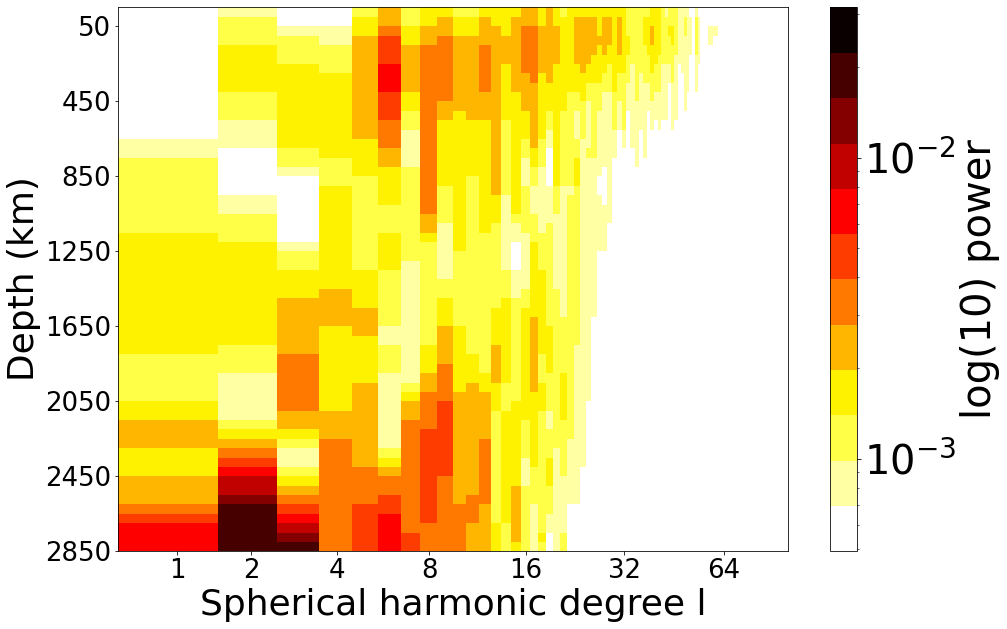

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# vmin/vmax for plot:
vmin = math.pow(10, -1.5) / 64.
vmax = math.pow(10, -1.5)
# colormap
cmap = cm.get_cmap("hot_r", 12)

pcm = ax.pcolor(power_per_l_all,
                cmap=cmap,
                norm=colors.LogNorm(vmin=vmin, vmax=vmax))

# colorbar
cb = plt.colorbar(pcm)
cb.ax.tick_params(labelsize=40)
cb.set_label("log(10) power", size=40)
#ax.grid()

# labels
plt.xlabel("Spherical harmonic degree l", size=36)
plt.ylabel("Depth (km)", size=36)
plt.xscale('log',basex=2) 

# x- and y-ticks
y_ticks = np.array(range(0, np.shape(power_per_l_all)[0], 8))
plt.yticks(y_ticks, 
           max_depth - interval_depth*y_ticks, 
           size=26)

x_ticks = [1, 2, 4, 8, 16, 32, 64]
#x_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.xticks(np.array(x_ticks)+0.5, 
           np.array(x_ticks), 
           size=26)
plt.xlim(1, 100)
#plt.grid()

plt.show()

## Filter tomography models (depth profiles)

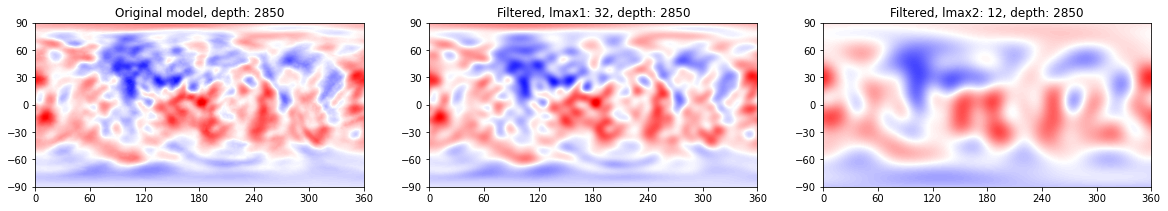

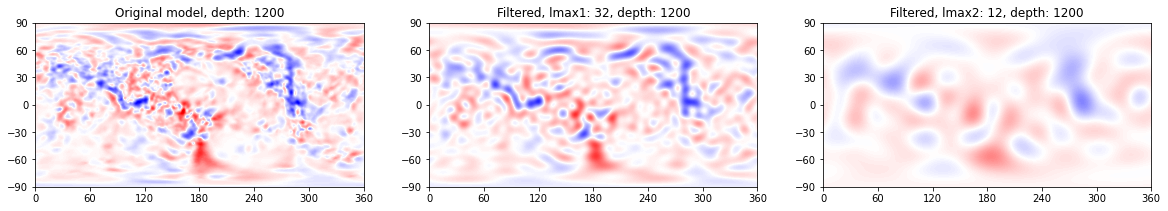

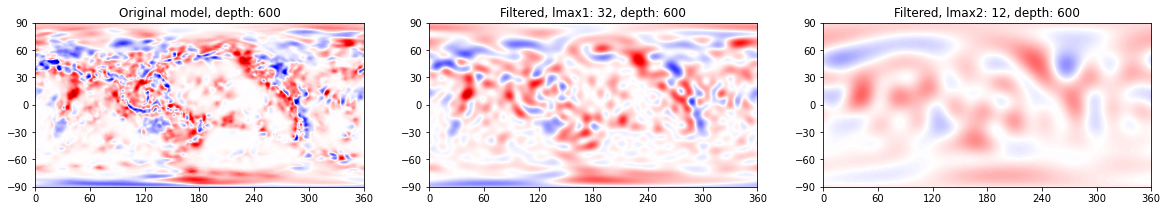

In [6]:
# max l for filtering
lmax1 = 32
lmax2 = 12
# list of depths to be used for plotting
list_depths = [2850, 1200, 600]
# vmin/vmax for plotting
vmin = -2
vmax = 2

for idep in list_depths:
    # USER: change the following path
    grid_add = './DETOX_MODELS/DETOX-P2/grid_nc4/DETOX-P2_%s.00.grd' % idep
    
    # See `Calculate Spherical Harmonics` cell for more info
    model = Dataset(grid_add)
    dv_v = model.variables['z'][:]
    dv_v = dv_v[::-1]

    coeffs = SHExpandDH(dv_v[:-1, :-1], sampling=2)
    nl = coeffs.shape[1]
    ls = np.arange(nl)
    power_per_l = spectrum(coeffs)

    # Filter coefficients
    # i.e., set lmax1: to zero
    coeffs_filtered = coeffs.copy()
    coeffs_filtered[:, lmax1:, :] = 0.
    tomo_filtered_lmax1 = MakeGridDH(coeffs_filtered, sampling=2)

    # i.e., set lmax2: to zero
    coeffs_filtered = coeffs.copy()
    coeffs_filtered[:, lmax2:, :] = 0.
    tomo_filtered_lmax2 = MakeGridDH(coeffs_filtered, sampling=2)
    
    # --- ORIGINAL MODEL
    plt.figure(figsize=(20, 5*len(list_depths)))
    plt.subplot(1, 3, 1)
    plt.imshow(dv_v, 
               extent=(-180, 180, -90, 90), 
               cmap='seismic_r', 
               vmin=vmin, 
               vmax=vmax)
    plt.xticks(np.arange(-180, 180+60, 60), 
               np.arange(0, 360+60, 60))
    plt.yticks(np.arange(-90, 90+30, 30))
    plt.title(f"Original model, depth: {idep}")
    
    # --- FILTERED: LMAX1
    plt.subplot(1, 3, 2)
    plt.imshow(tomo_filtered_lmax1, 
               extent=(-180, 180, -90, 90), 
               cmap='seismic_r', 
               vmin=vmin, 
               vmax=vmax)
    plt.xticks(np.arange(-180, 180+60, 60), 
               np.arange(0, 360+60, 60))
    plt.yticks(np.arange(-90, 90+30, 30))
    plt.title(f'Filtered, lmax1: {lmax1}, depth: {idep}')

    # --- FILTERED: LMAX2
    plt.subplot(1, 3, 3)
    plt.imshow(tomo_filtered_lmax2, 
               extent=(-180, 180, -90, 90), 
               cmap='seismic_r', 
               vmin=vmin, 
               vmax=vmax)
    plt.xticks(np.arange(-180, 180+60, 60), 
               np.arange(0, 360+60, 60))
    plt.yticks(np.arange(-90, 90+30, 30))
    plt.title(f'Filtered, lmax2: {lmax2}, depth: {idep}')
    
plt.show()

## Compare models

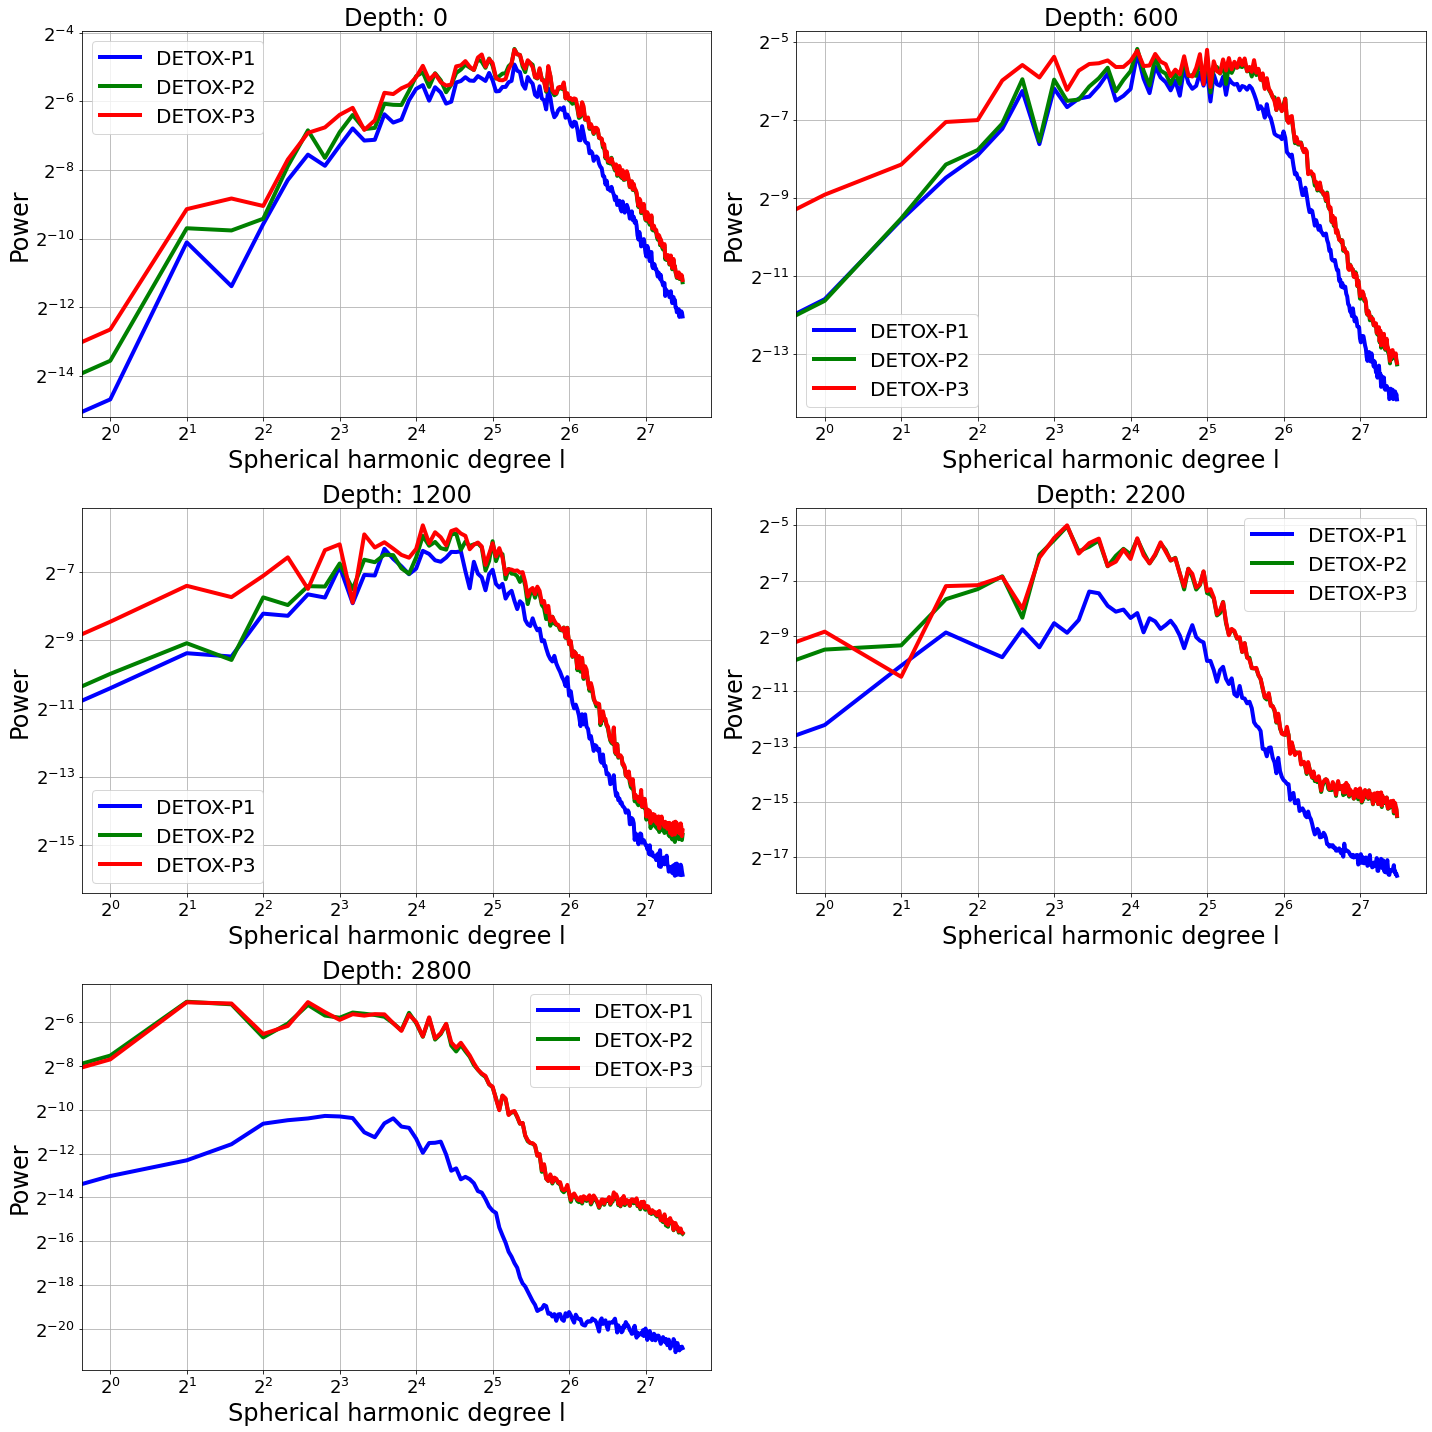

In [7]:
# List of depths
tar_depths = [0, 600, 1200, 2200, 2800]
# Compare these models
model_list = ["DETOX-P1", "DETOX-P2","DETOX-P3"]
colors = ["b", "g", "r"]

plt.figure(figsize=(20, 4*len(tar_depths)))
for i, tar_depth in enumerate(tar_depths):
    plt.subplot(math.ceil(len(tar_depths)/2.), 2, i+1)
    for i, one_model in enumerate(model_list):
        grid_add = f'./DETOX_MODELS/{one_model}/grid_nc4/{one_model}_{tar_depth}.00.grd'

        # See `Calculate Spherical Harmonics` cell for more info
        model = Dataset(grid_add)
        dv_v = model.variables['z'][:]
        dv_v = dv_v[::-1]

        coeffs = SHExpandDH(dv_v[:-1, :-1], sampling=2)
        nl = coeffs.shape[1]
        ls = np.arange(nl)
        power_per_l = spectrum(coeffs, unit='per_dlogl', base=2.)

        plt.plot(ls, power_per_l, 
                 c=colors[i],
                 lw=4,
                 label=one_model)

    plt.title(f"Depth: {tar_depth}", size=24)
    plt.xticks(size=18)
    plt.yticks(size=18)
    plt.yscale('log', basey=2)
    plt.xscale('log', basex=2)
    # labels
    plt.xlabel("Spherical harmonic degree l", size=24)
    plt.ylabel("Power", size=24)

    plt.legend(fontsize=20)
    plt.grid()
plt.tight_layout()
plt.show()